# REGRESSION

In [1]:
# import the libraries

%matplotlib inline

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn :: utils
from sklearn.model_selection import train_test_split

# sklearn :: models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# sklearn :: evaluation
from sklearn.metrics import mean_squared_error

# convert scientific notation to decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style('whitegrid')

# Problem definition

Predict the avg. expected delay.

________________________
# Load Data

### Cleaned, Merged dataset can be downloaded from here: https://www.kaggle.com/arwasheraky/cleaned-flight-delays-2015

In [2]:
df_flights = pd.read_csv('data/flightsmerged.csv', low_memory=False)

In [3]:
df_flights.head()

,MONTH,FLIGHT_NUMBER,TAIL_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,...,ORIGIN_AC,ORIGIN_NAME,ORIGIN_STATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_AC,DESTINATION_NAME,DEST_STATE,DEST_LATITUDE,DEST_LONGITUDE
0,1,98,N407AS,00:05:00,23:54:00,-11.00,205.00,1448,04:30:00,04:08:00,...,ANC,Ted Stevens Anchorage International Airport,AK,61.17,-150.00,SEA,Seattle-Tacoma International Airport,WA,47.45,-122.31
1,1,2336,N3KUAA,00:10:00,00:02:00,-8.00,280.00,2330,07:50:00,07:41:00,...,LAX,Los Angeles International Airport,CA,33.94,-118.41,PBI,Palm Beach International Airport,FL,26.68,-80.10
2,1,840,N171US,00:20:00,00:18:00,-2.00,286.00,2296,08:06:00,08:11:00,...,SFO,San Francisco International Airport,CA,37.62,-122.37,CLT,Charlotte Douglas International Airport,NC,35.21,-80.94
3,1,258,N3HYAA,00:20:00,00:15:00,-5.00,285.00,2342,08:05:00,07:56:00,...,LAX,Los Angeles International Airport,CA,33.94,-118.41,MIA,Miami International Airport,FL,25.79,-80.29
4,1,135,N527AS,00:25:00,00:24:00,-1.00,235.00,1448,03:20:00,02:59:00,...,SEA,Seattle-Tacoma International Airport,WA,47.45,-122.31,ANC,Ted Stevens Anchorage International Airport,AK,61.17,-150.00


In [4]:
df_flights.columns

Index(['MONTH', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'SCHEDULED_DEPARTURE',
       'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'DISTANCE',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED',
       'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY', 'DATE', 'CLASS', 'AIRLINE_CODE', 'AIRLINE_NAME',
       'ORIGIN_AC', 'ORIGIN_NAME', 'ORIGIN_STATE', 'ORIGIN_LATITUDE',
       'ORIGIN_LONGITUDE', 'DESTINATION_AC', 'DESTINATION_NAME', 'DEST_STATE',
       'DEST_LATITUDE', 'DEST_LONGITUDE'],
      dtype='object')

____

# Feature Engineering

In [5]:
# Keep just the delayed and on_time flights, remove the cancelled and early flights.

df = df_flights[(df_flights['CLASS'] == 'On_Time') | (df_flights['CLASS'] == 'Delayed')]
df = df.drop(columns = ['CANCELLATION_REASON','CANCELLED'])
print("Original dataset : ",df_flights.shape)
print("Now : ",df.shape)

Original dataset :  (5697506, 33)
Now :  (5608236, 31)


## Add a column

In [6]:
# Average delay column --> Predicited column

df['AVG_DELAY'] = 0
df['AVG_DELAY'] = (df['DEPARTURE_DELAY'] + df['ARRIVAL_DELAY']) / 2.0
df['AVG_DELAY'].head(10)

0   -16.50
1    -8.50
2     1.50
3    -7.00
4   -11.00
5     1.50
6   -11.50
7     2.00
8   -12.00
9    -6.00
Name: AVG_DELAY, dtype: float64

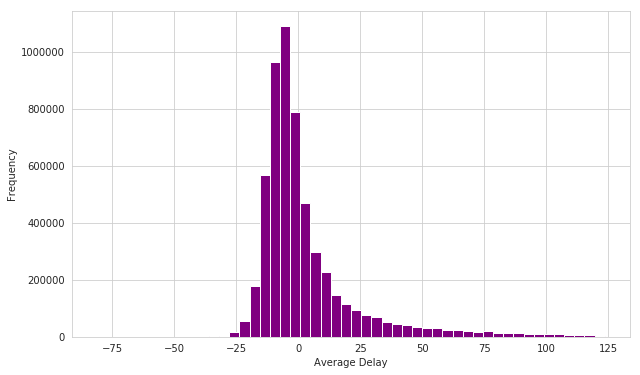

In [7]:
plt.figure(figsize=(10,6))
plt.hist(df['AVG_DELAY'], bins=50, color='purple')
plt.xlabel("Average Delay")
plt.ylabel("Frequency")
plt.show()

In [8]:
# sns.regplot(x = df['DEPARTURE_DELAY'] , y = df['ARRIVAL_DELAY'], color = "r")
# plt.title("DEPARTURE_DELAY vs ARRIVAL_DELAY")
# plt.xlabel("DEPARTURE_DELAY")
# plt.ylabel("ARRIVAL_DELAY")
# plt.show()

## Label encoding

In [9]:
# get_dummies

# Convert FLIGHT_NUMBER to STRING
#for idx in df.index:
#    df.at[idx,'FLIGHT_NUMBER'] = str(df.at[idx,'FLIGHT_NUMBER'])

# Convert MONTH to STRING
df['MONTH'] = df['MONTH'].replace(to_replace = list(range(1, 13)),
                                  value=['1','2','3','4','5','6','7','8','9','10','11','12'])

categorical = ['AIRLINE_NAME','MONTH','DEST_STATE','ORIGIN_STATE','DESTINATION_AC','ORIGIN_AC']

df_dummies = pd.get_dummies(df[categorical])
df = pd.concat([df, df_dummies], axis=1)


In [10]:
df.columns

Index(['MONTH', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'SCHEDULED_DEPARTURE',
       'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'DISTANCE',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       ...
       'ORIGIN_AC_TYS', 'ORIGIN_AC_UST', 'ORIGIN_AC_VEL', 'ORIGIN_AC_VLD',
       'ORIGIN_AC_VPS', 'ORIGIN_AC_WRG', 'ORIGIN_AC_WYS', 'ORIGIN_AC_XNA',
       'ORIGIN_AC_YAK', 'ORIGIN_AC_YUM'],
      dtype='object', length=810)

## Change Time to Int

In [11]:
# Convert the time to seconds

def time_to_num (time_str):
    
    if type(time_str) is int:
        return time_str
    
    h,m,s = time_str.split(':')
    result = int(h) * 3600 + int(m) * 60 + int(s)
    return result

In [12]:
# Call the Function:

df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].apply(time_to_num)
df['SCHEDULED_ARRIVAL'] =df['SCHEDULED_ARRIVAL'].apply(time_to_num)

#Print a sample..
df[['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL']].head()

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL
0,300,16200
1,600,28200
2,1200,29160
3,1200,29100
4,1500,12000


## Change Date to Int

In [13]:
from datetime import datetime

def date_to_int(time_str):
    
    if type(time_str) is float:
        return time_str
    
    result = datetime.fromisoformat(time_str).timestamp()
    return result

In [14]:
# Call the Function:

df['DATE'] = df['DATE'].apply(date_to_int)
df['DATE'].head()

0   1420088400.00
1   1420088400.00
2   1420088400.00
3   1420088400.00
4   1420088400.00
Name: DATE, dtype: float64

## Select Model Columns

In [15]:
# After first run: Get the columns with feature importance > 0.0001
#X_columns = features_imp_005[0].values

# Original columns
X_columns = ['SCHEDULED_ARRIVAL','SCHEDULED_DEPARTURE','DATE',] + list(df_dummies.columns)

y_column = ['AVG_DELAY']

len(X_columns)

781

In [16]:
# splitting the data

threshold = 0.7

X = df[X_columns].fillna(0.0)
y = df[y_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0-threshold, shuffle=True, random_state=50)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (3925765, 781)
y_train (3925765, 1)
X_test (1682471, 781)
y_test (1682471, 1)


In [17]:
# corr_matrix = df.corr()
# corr_matrix.sort_values(by='DEPARTURE_DELAY')

_________
# Training and Testing The Models

In [18]:
# Select a subset of the data, to avoid waiting long time beacause of it's enormous size.

X_train = X_train.iloc[:200000,:]
y_train = y_train.iloc[:200000,:]
X_test = X_test.iloc[:50000,:]
y_test = y_test.iloc[:50000,:]

In [19]:
rf_model = RandomForestRegressor(n_estimators =20)
rf_model.fit(X_train, y_train.values.ravel())
rf_pred = rf_model.predict(X_test)

In [20]:
gb_model = GradientBoostingRegressor(n_estimators =20)
gb_model.fit(X_train, y_train.values.ravel())
gb_pred = gb_model.predict(X_test)

In [21]:
knn_model = KNeighborsRegressor(10)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

In [22]:
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)

____________
# Models Evaluation

RMSE 21.274601707200066


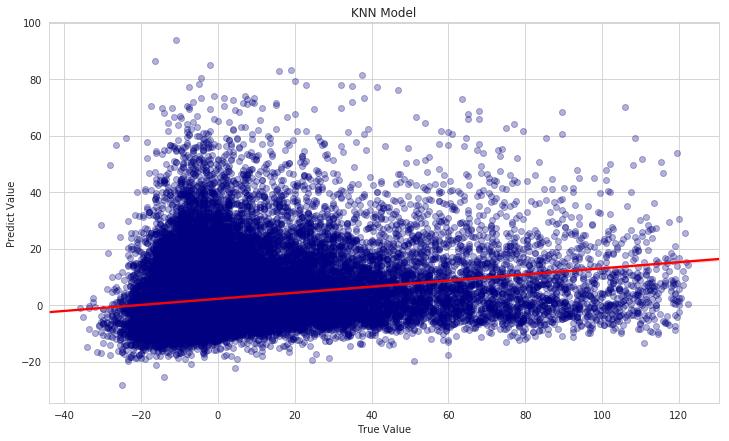

In [23]:
rmse = np.sqrt(mean_squared_error(y_test, knn_pred))
print('RMSE', rmse)

plt.figure(figsize=(12,7))
sns.regplot(y_test, rf_pred, color='navy', scatter_kws={'alpha':0.3}, line_kws={'color': 'red'})
plt.title('KNN Model')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.show()

RMSE 27.9411727563465


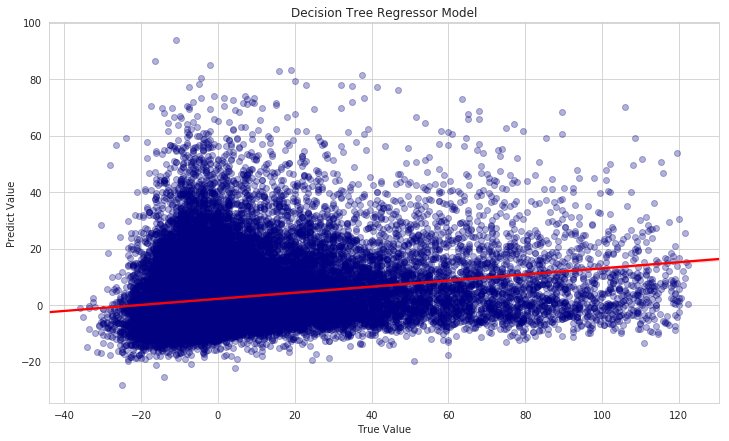

In [24]:
rmse = np.sqrt(mean_squared_error(y_test, tree_pred))
print('RMSE', rmse)

plt.figure(figsize=(12,7))
sns.regplot(y_test, rf_pred, color='navy', scatter_kws={'alpha':0.3}, line_kws={'color': 'red'})
plt.title('Decision Tree Regressor Model')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.show()

RMSE 21.625526888166345


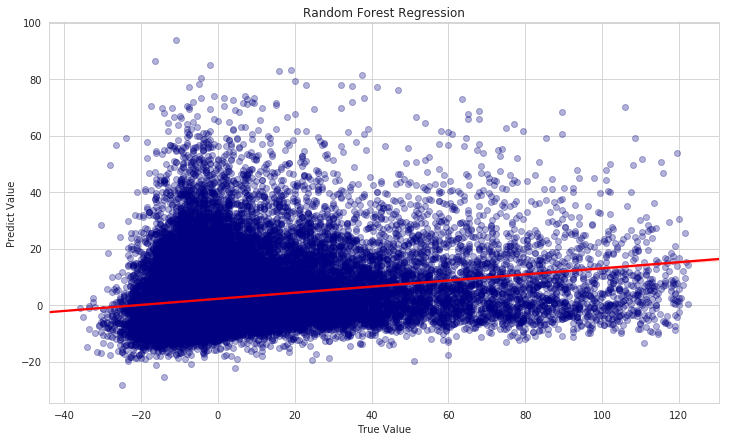

In [25]:
rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
print('RMSE', rmse)

plt.figure(figsize=(12,7))
sns.regplot(y_test, rf_pred, color='navy', scatter_kws={'alpha':0.3}, line_kws={'color': 'red'})
plt.title('Random Forest Regression')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.show()

RMSE 20.71333220580721


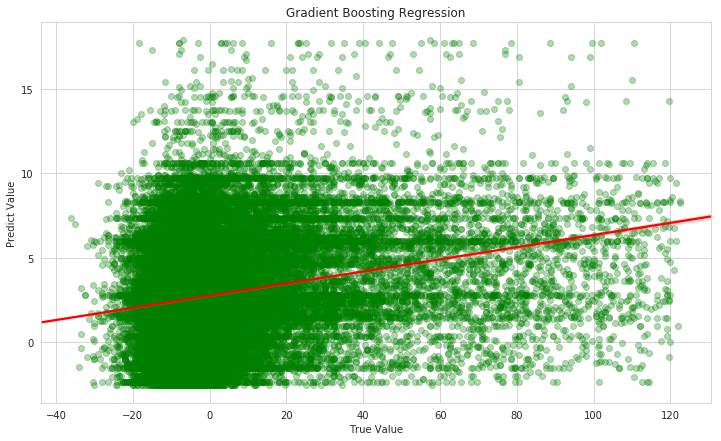

In [26]:
rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
print('RMSE', rmse)

plt.figure(figsize=(12,7))
sns.regplot(y_test, gb_pred, color = 'green', scatter_kws={'alpha':0.3}, line_kws={'color': 'red'})
plt.title('Gradient Boosting Regression')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.show()

In [27]:
# identigy the feature importance

importance = []
model = gb_model

for i in range(len(X_columns)):
    importance.append([X_columns[i], model.feature_importances_[i]])

features_imp = pd.DataFrame(importance).sort_values(by=1, ascending=False)
features_imp

,0,1
1,SCHEDULED_DEPARTURE,0.44
2,DATE,0.35
0,SCHEDULED_ARRIVAL,0.08
12,AIRLINE_NAME_Southwest Airlines Co.,0.05
7,AIRLINE_NAME_Delta Air Lines Inc.,0.04
13,AIRLINE_NAME_Spirit Air Lines,0.01
25,MONTH_6,0.01
3,AIRLINE_NAME_Alaska Airlines Inc.,0.01
21,MONTH_2,0.00
10,AIRLINE_NAME_JetBlue Airways,0.00


In [28]:
features_imp_0001 = features_imp[features_imp[1] > 0.0001]
features_imp_0001

,0,1
1,SCHEDULED_DEPARTURE,0.44
2,DATE,0.35
0,SCHEDULED_ARRIVAL,0.08
12,AIRLINE_NAME_Southwest Airlines Co.,0.05
7,AIRLINE_NAME_Delta Air Lines Inc.,0.04
13,AIRLINE_NAME_Spirit Air Lines,0.01
25,MONTH_6,0.01
3,AIRLINE_NAME_Alaska Airlines Inc.,0.01
21,MONTH_2,0.00
10,AIRLINE_NAME_JetBlue Airways,0.00


# Prepare submission

In [30]:
from joblib import dump, load

In [33]:
dump(model, 'gb_model.pkl') 

['gb_model.pkl']